### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import shutil
import random

2022-12-14 15:05:16.666476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Creating new folders for respective classes

In [ ]:

os.mkdir('dogs-vs-cats/images/cat')
os.mkdir('dogs-vs-cats/images/dog')

folder = 'dogs-vs-cats/images/'

for file in os.listdir(folder):
    if file.startswith('cat.'):
        shutil.move(folder + file, folder + 'cat')
    elif file.startswith('dog.'):
        shutil.move(folder + file, folder + 'dog')
        


### Removing images

In [14]:
files = os.listdir('dogs-vs-cats/images/cat')
for file in random.sample(files,12000):
    os.remove('dogs-vs-cats/images/cat/' + file)

files = os.listdir('dogs-vs-cats/images/dog')
for file in random.sample(files,12000):
    os.remove('dogs-vs-cats/images/dog/' + file)
    


### Set image directory

In [3]:
image_dir = Path('../cats-and-dogs-data-mining/dogs-vs-cats/images/')

### Create filepath dataframe

In [4]:
filepaths = list(image_dir.glob(r'**/*.jpg')) #find all .jpg files within the current folder
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths)) #how we pull labels

filepaths = pd.Series(filepaths, name = 'Filepath').astype(str)
labels = pd.Series(labels, name = 'Label')

image_df = pd.concat([filepaths, labels], axis = 1)

### Train-Test Split

In [5]:
train_df, test_df = train_test_split(image_df, train_size = 0.7, shuffle = True, random_state = 1)

### Load Image Data

In [6]:
# Allows us to load a subset of images at a time, train them and recycle the memory so we don't run out
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, # scale pixel intensity values from 0 - 255 down to 0 - 1
    horizontal_flip=True, # Make our model more resilient to horizontally flipped pics
    width_shift_range=0.2, # Shift width by 20%
    height_shift_range=0.2, # Shift height by 20%
    validation_split = 0.2 # Pull train and test images through the same generato
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [7]:
# Flow the images (specify how the images will be loaded)
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col="Filepath",
    y_col="Label",
    target_size = (224,224), # Standardize image size
    color_mode='rgb', # Our images are colorized
    class_mode='binary', # we have 2 classes only
    batch_size = 32, # how many images to load at a time
    shuffle = True, # Shuffle for training
    seed=42, # makes sure the shuffling is always the same way, and always the same subset
    subset = 'training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col="Filepath",
    y_col="Label",
    target_size = (224,224), # Standardize image size
    color_mode='rgb', # Our images are colorized
    class_mode='binary', # we have 2 classes only
    batch_size = 32, # how many images to load at a time
    shuffle = True, # Shuffle for training
    seed=42, # makes sure the shuffling is always the same way, and always the same subset
    subset = 'validation'
)

test_images = train_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col="Filepath",
    y_col="Label",
    target_size = (224,224), # Standardize image size
    color_mode='rgb', # Our images are colorized
    class_mode='binary', # we have 2 classes only
    batch_size = 32, # how many images to load at a time
    shuffle = False, # False since we are only evaluating, not training
)

Found 560 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


### Model Training

In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3)) # One for each color channel
# 16 filters, kernal size of 3x3. 
# The convolutional layer will look at the image, slide a window across the image, and the window
# weights will multiply by the pixel values, sum them up, and send that to a new 2D feature
# We will end up with a new 2D array with the values. 
# Filters specify how many times we want to do this full pass over the image.
# The kernal size represents how big the window is
# The whole point of a Convolutional Neural Network is to extract features that 
# are useful for predicting
# If we were to pass each pixel as an individual feature, the model would be too complex and likely
# overfit. Also, there is no way to capture the spatial relationship between the data
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
# maxpool also sends a window across the image, and takes a max of 4 pixels.
# allows the next convolutional data to reduce the dimensions of the data and keep the most
# important pixels (simplified, high level view of each image)
# Each time we maxpool, we lose information, but make it easier for the next layer to grasp
# high level relationships in the data
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
# Average over the first 2 dimensions so that we just end up with 32 features. 
# These features could be anything like pointy ears for cats, or floppy ears for dogs
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# create the actual classifier, a 2 hidden layer dense NN
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
# outputs is another dense layer with 1 output value and sigmoid activation since
# it is a binary classification task
# sigmoid gives it the effect of being betweem 0 or 1
# so the output is a single prob estimate of the prob that one of the classes is present in the image
# In this case, 1 = dog and 0 = cat
# So the output is the probability of a dog since that is the positive class
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = tf.keras.Model(inputs = inputs, outputs = outputs)

# Model compiler with adam optimizer, binary crossentropy loss, and accuracy as the metric
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# 100 epochs with early stopping callback. Early stopping will look at the validation loss so we can
# monitor the validation loss, when the val loss has not improved after 5 epochs, it will stop
# training and restore the weights from the best epoch
# We chose to reduce the learning rate to stabilize model training. Validation loss was fluctuating
# a lot previously.
history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = "val_loss",
            patience = 5,
            restore_best_weights = True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_loss",
            patience = 3
        )
    ]
)

2022-12-14 15:06:17.098489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
18/18 [==============================] - 19s 960ms/step - loss: 0.6934 - accuracy: 0.5036 - val_loss: 0.6905 - val_accuracy: 0.5071 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 16s 878ms/step - loss: 0.6911 - accuracy: 0.5000 - val_loss: 0.6890 - val_accuracy: 0.5071 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 19s 1s/step - loss: 0.6904 - accuracy: 0.5304 - val_loss: 0.6856 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 16s 874ms/step - loss: 0.6867 - accuracy: 0.5179 - val_loss: 0.6801 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 16s 889ms/step - loss: 0.6831 - accuracy: 0.5500 - val_loss: 0.6796 - val_accuracy: 0.5857 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 16s 869ms/step - loss: 0.6763 - accuracy: 0.5696 - val_loss: 0.6751 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 16s 895m

### Evaluation of Results

In [9]:
# Pull our results as a numpy array
results = model.evaluate(test_images, verbose = 0) 

# Display the loss value to 5 decimal places format that with results[0]
# The first value returned will be the loss, the second value will be the accuracy.
print('    Test Loss: {:.5f}'.format(results[0]))
print('Test Accuracy: {:.2f}'.format(results[1] * 100))

# About 64% accuracy. Better than randomly guessing!

    Test Loss: 0.65541
Test Accuracy: 63.67


10/10 [==============================] - 7s 670ms/step


/var/folders/tb/b14t5svn6qs25f_zj864ykdm0000gn/T/ipykernel_92105/1115919309.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = (model.predict(test_images) >= 0.5).astype(np.int)


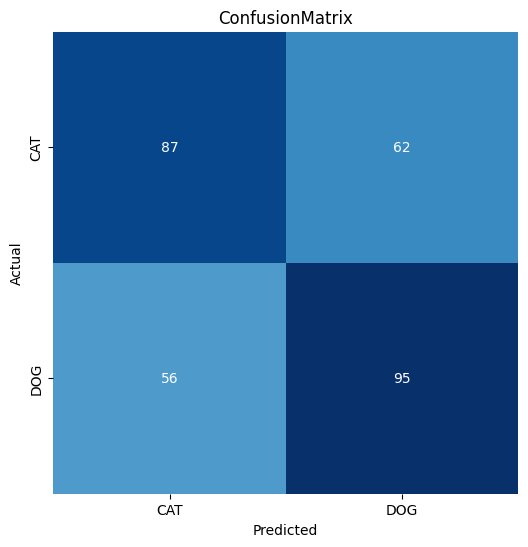

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.61      0.58      0.60       149
         DOG       0.61      0.63      0.62       151

    accuracy                           0.61       300
   macro avg       0.61      0.61      0.61       300
weighted avg       0.61      0.61      0.61       300



In [10]:
# model.predict returns the probability estimate for the image being a dog
# we want the classification, not estimate
# so we can predict on the test_images, and for each value check if it is at least 0.5
# If the prob is > 0.5, it will classify as a dog 
# This returns a boolean array for each test image
# setting .astype returns 0 or 1 instead of true/false
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

# Create confusion matrix.
# .labels are the actual values for the images
# labels ensures that cats come first, then dogs
cm = confusion_matrix(test_images.labels, predictions, labels = [0,1])

# Create classification report
# Pass the same arguments but add target names
clr = classification_report(test_images.labels, predictions, labels = [0,1], target_names = ["CAT","DOG"])

# Create figure size
plt.figure(figsize=(6,6))
# Seaborn heatmap to plot the confusion matix
# annotations on, fmt = g avoids scientific notation
# Minimum value is 0, color map set to blues, color bar set to off
sns.heatmap(cm, annot = True, fmt = 'g', vmin = 0, cmap = 'Blues', cbar = False)

# Add some tick marks
# ticks = spacing of the tick marks
# Lables should be in the same order as earlier
plt.xticks(ticks = [0.5,1.5], labels = ["CAT", "DOG"])
plt.yticks(ticks = [0.5,1.5], labels = ["CAT", "DOG"])

# Setting axis labels
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ConfusionMatrix")

# Show that plot and report
plt.show()
print("Classification Report:\n----------------------\n", clr)

# Out of all the actual cats, 58% were predicted correctly
# Out of all the actual dogs, 63% were predicted correctly
